In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_images = 1
img_dim = 64 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 80
psf_stdev = 1
background_intensity = 19200

prior = CatalogPrior(max_objects = max_objects,
                     img_height = img_height,
                     img_width = img_width,
                     min_flux = background_intensity/3.)

image_attributes = ImageAttributes(img_height = img_height,
                                   img_width = img_width,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(prior, num_images)

image 1 
count
 71 
total flux
 4511154.5 
loc
 [[4.89389954e+01 2.94719982e+01]
 [5.46142483e+00 3.60750809e+01]
 [9.63104248e+00 4.24796867e+01]
 [6.34954357e+00 1.97884521e+01]
 [5.16549263e+01 2.90148792e+01]
 [3.41840515e+01 5.95249863e+01]
 [4.58836098e+01 2.52592042e-02]
 [5.16035309e+01 3.53400040e+01]
 [3.98173676e+01 3.68644295e+01]
 [4.26799011e+01 3.51419525e+01]
 [2.03575573e+01 1.30084381e+01]
 [3.40559883e+01 5.47384453e+01]
 [5.31707573e+01 5.97809181e+01]
 [2.10709133e+01 4.33418617e+01]
 [1.99890175e+01 4.08601036e+01]
 [2.96834278e+01 7.34411097e+00]
 [8.17805862e+00 2.18413734e+00]
 [1.59891205e+01 6.00166206e+01]
 [4.02549782e+01 4.97428741e+01]
 [3.85500107e+01 2.43566551e+01]
 [2.41464367e+01 8.06881142e+00]
 [5.05413055e+01 5.35402727e+00]
 [1.42739639e+01 6.01621389e+00]
 [1.20492401e+01 3.90546646e+01]
 [4.09982796e+01 2.46123085e+01]
 [8.86080563e-01 3.03266792e+01]
 [4.36858013e-02 3.14031410e+01]
 [2.71110859e+01 3.83970947e+01]
 [3.15287800e+01 1.86897774e

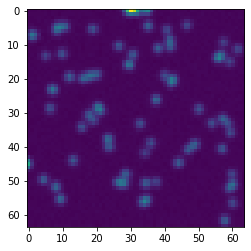

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

In [4]:
tile_side_length = 4
max_objects_smc = 2
pad = 2

prior = CatalogPrior(max_objects_smc,
                     tile_side_length, tile_side_length,
                     background_intensity/3.,
                     pad)

smc = SMCsampler(images[0], image_attributes, tile_side_length, prior,
                 max_objects = max_objects_smc, catalogs_per_block = 200,
                 kernel_num_iters = 100, product_form_multiplier = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 71
True total flux: 4511154.5

Starting the tile samplers...
iteration 5, temperature = 0.0015757393557578325
iteration 10, temperature = 0.011665459722280502
iteration 15, temperature = 0.06281778216362
iteration 20, temperature = 0.32919254899024963
Done!

Combining the results...
Done!

Pruning detections...
Done!

summary
number of SMC iterations: 23
posterior mean count: 70.54769897460938
posterior mean total flux: 4437812.5



